<a href="https://colab.research.google.com/github/ManojKesani/my_sandbox/blob/master/FNMA_SH18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Modules**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Anamoly\ Detection/2018Q1.zip -d /content

Archive:  /content/drive/MyDrive/Anamoly Detection/2018Q1.zip
  inflating: /content/Acquisition_2018Q1.txt  
  inflating: /content/Performance_2018Q1.txt  


In [3]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
# import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
#import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import glob

import random
RANDOM_SEED = 42
TRAINING_SAMPLE = 0.99
BATCH_SIZE = 32
LATENT_DIMENSION = 16

from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn_pandas import DataFrameMapper, gen_features

from scipy import sparse

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [4]:
# print("Available GPUS : ", keras.backend.tensorflow_backend._get_available_gpus())

## **Loading Data**

In [5]:
ACQUISITION_FEATURES = ["LOAN IDENTIFIER", 
                             "ORIGINATION CHANNEL", 
                             "SELLER NAME", 
                             "ORIGINAL INTEREST RATE", 
                             "ORIGINAL UPB", 
                             "ORIGINAL LOAN TERM", 
                             "ORIGINATION DATE", 
                             "FIRST PAYMENT DATE", 
                             "ORIGINAL LOAN-TO-VALUE (LTV)", 
                             "ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)", 
                             "NUMBER OF BORROWERS", 
                             "ORIGINAL DEBT TO INCOME RATIO", 
                             "BORROWER CREDIT SCORE AT ORIGINATION", 
                             "FIRST TIME HOME BUYER INDICATOR",
                             "LOAN PURPOSE",
                             "PROPERTY TYPE",
                             "NUMBER OF UNITS",
                             "OCCUPANCY TYPE",
                             "PROPERTY STATE",
                             "ZIP CODE SHORT",
                             "PRIMARY MORTGAGE INSURANCE PERCENT",
                             "PRODUCT TYPE", "CO-BORROWER CREDIT SCORE AT ORIGINATION",
                             "MORTGAGE INSURANCE TYPE",
                             "RELOCATION MORTGAGE INDICATOR"]

PERFORMANCE_FEATURES = ["LOAN IDENTIFIER",
                             "MONTHLY REPORTING PERIOD",
                             "SERVICER NAME",
                             "CURRENT INTEREST RATE",
                             "CURRENT ACTUAL UPB",
                             "LOAN AGE",
                             "REMAINING MONTHS TO LEGAL MATURITY",
                             "ADJUSTED MONTHS TO MATURITY",
                             "MATURITY DATE",
                             "METROPOLITAN STATISTICAL AREA (MSA)",
                             "CURRENT LOAN DELINQUENCY STATUS",
                             "MODIFICATION FLAG",
                             "ZERO BALANCE CODE",
                             "ZERO BALANCE EFFECTIVE DATE",
                             "LAST PAID INSTALLMENT DATE",
                             "FORECLOSURE DATE",
                             "DISPOSITION DATE",
                             "FORECLOSURE COSTS",
                             "PROPERTY PRESERVATION AND REPAIR COSTS",
                             "ASSET RECOVERY COSTS",
                             "MISCELLANEOUS HOLDING EXPENSES AND CREDITS",
                             "ASSOCIATED TAXES FOR HOLDING PROPERTY",
                             "NET SALE PROCEEDS",
                             "CREDIT ENHANCEMENT PROCEEDS",
                             "REPURCHASE MAKE WHOLE PROCEEDS",
                             "OTHER FORECLOSURE PROCEEDS",
                             "NON INTEREST BEARING UPB",
                             "PRINCIPAL FORGIVENESS AMOUNT",
                             "REPURCHASE MAKE WHOLE PROCEEDS FLAG",
                             "FORECLOSURE PRINCIPAL WRITE-OFF AMOUNT",
                             "SERVICING ACTIVITY INDICATOR"]

REL_ACQUISITION_FEATURES = ["LOAN IDENTIFIER",
                            "BORROWER CREDIT SCORE AT ORIGINATION",
                            "CO-BORROWER CREDIT SCORE AT ORIGINATION",
                            "FIRST TIME HOME BUYER INDICATOR",
                            "MORTGAGE INSURANCE TYPE",
                            "NUMBER OF BORROWERS",
                            "NUMBER OF UNITS",
                            "OCCUPANCY TYPE",
                            "ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)",
                            "ORIGINAL DEBT TO INCOME RATIO",
                            "ORIGINATION CHANNEL",
                            "ORIGINAL INTEREST RATE",
                            "ORIGINAL LOAN TERM",
                            "ORIGINAL LOAN-TO-VALUE (LTV)",
                            "ORIGINAL UPB",
                            "PRIMARY MORTGAGE INSURANCE PERCENT",
                            "PRODUCT TYPE",
                            "PROPERTY TYPE",
                            "RELOCATION MORTGAGE INDICATOR",
                            "SELLER NAME"]

REL_PERFORMANCE_FEATURES = ["LOAN IDENTIFIER",
                            "ADJUSTED MONTHS TO MATURITY",
                            "CURRENT ACTUAL UPB",
                            "CURRENT INTEREST RATE",
                            "CURRENT LOAN DELINQUENCY STATUS",
                            "LOAN AGE",
                            "MODIFICATION FLAG",
                            "NON INTEREST BEARING UPB",
                            "PRINCIPAL FORGIVENESS AMOUNT",
                            "REMAINING MONTHS TO LEGAL MATURITY",
                            "SERVICING ACTIVITY INDICATOR",
                            "ZERO BALANCE CODE"]

In [6]:
path = "/content" # use your path
performance_files = glob.glob(path + "/Performance_*.txt")
acquisition_files = glob.glob(path + "/Acquisition_*.txt")

print(performance_files)
print(acquisition_files)

def data_to_dataframe(files, features):
    li = []

    for filename in files:
        df = pd.read_csv(filename, sep = "|", names = features, index_col=None, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

acq_df = data_to_dataframe(acquisition_files, ACQUISITION_FEATURES)
per_df = data_to_dataframe(performance_files, PERFORMANCE_FEATURES)

['/content/Performance_2018Q1.txt']
['/content/Acquisition_2018Q1.txt']


In [7]:
per_df = per_df.loc[per_df["ZERO BALANCE CODE"].notnull(), REL_PERFORMANCE_FEATURES]
df = per_df.merge(acq_df[REL_ACQUISITION_FEATURES], on = "LOAN IDENTIFIER", how = "inner")

In [8]:
df.head()

,LOAN IDENTIFIER,ADJUSTED MONTHS TO MATURITY,CURRENT ACTUAL UPB,CURRENT INTEREST RATE,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,MODIFICATION FLAG,NON INTEREST BEARING UPB,PRINCIPAL FORGIVENESS AMOUNT,REMAINING MONTHS TO LEGAL MATURITY,SERVICING ACTIVITY INDICATOR,ZERO BALANCE CODE,BORROWER CREDIT SCORE AT ORIGINATION,CO-BORROWER CREDIT SCORE AT ORIGINATION,FIRST TIME HOME BUYER INDICATOR,MORTGAGE INSURANCE TYPE,NUMBER OF BORROWERS,NUMBER OF UNITS,OCCUPANCY TYPE,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT TO INCOME RATIO,ORIGINATION CHANNEL,ORIGINAL INTEREST RATE,ORIGINAL LOAN TERM,ORIGINAL LOAN-TO-VALUE (LTV),ORIGINAL UPB,PRIMARY MORTGAGE INSURANCE PERCENT,PRODUCT TYPE,PROPERTY TYPE,RELOCATION MORTGAGE INDICATOR,SELLER NAME
0,100012691523,0.0,176202.25,5.375,X,18,N,NaN,NaN,342,NaN,1.0,690.0,NaN,N,NaN,1,1,P,80.0,14.0,R,5.375,360,80,180000,NaN,FRM,PU,N,OTHER
1,100021639708,0.0,219327.38,3.990,X,22,N,NaN,NaN,338,NaN,1.0,757.0,NaN,N,NaN,1,1,P,80.0,42.0,R,3.990,360,80,227000,NaN,FRM,PU,N,"QUICKEN LOANS, LLC"
2,100031627426,0.0,345644.81,4.375,X,18,N,NaN,NaN,342,NaN,1.0,767.0,NaN,N,1.0,1,1,P,85.0,28.0,R,4.375,360,85,368000,12.0,FRM,PU,N,OTHER
3,100038288795,0.0,170503.63,4.625,X,15,N,NaN,NaN,345,NaN,1.0,748.0,NaN,N,NaN,1,1,P,74.0,29.0,R,4.625,360,74,174000,NaN,FRM,SF,N,OTHER
4,100043464862,0.0,290100.23,4.375,X,24,N,NaN,NaN,336,NaN,1.0,751.0,724.0,N,NaN,2,1,P,80.0,43.0,C,4.375,360,80,300000,NaN,FRM,PU,N,"WELLS FARGO BANK, N.A."


## **Data Preprocessing and Cleaning**

In [9]:
# Data Shape and Data Info
print(df.shape)
print(df.info())
# Checking for missing data
print(df.isnull().sum())

(86449, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 86449 entries, 0 to 86448
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   LOAN IDENTIFIER                          86449 non-null  int64  
 1   ADJUSTED MONTHS TO MATURITY              86449 non-null  float64
 2   CURRENT ACTUAL UPB                       86447 non-null  float64
 3   CURRENT INTEREST RATE                    86449 non-null  float64
 4   CURRENT LOAN DELINQUENCY STATUS          86264 non-null  object 
 5   LOAN AGE                                 86449 non-null  int64  
 6   MODIFICATION FLAG                        86449 non-null  object 
 7   NON INTEREST BEARING UPB                 0 non-null      float64
 8   PRINCIPAL FORGIVENESS AMOUNT             0 non-null      float64
 9   REMAINING MONTHS TO LEGAL MATURITY       86449 non-null  int64  
 10  SERVICING ACTIVITY INDICATOR      

In [10]:
df.drop(["ADJUSTED MONTHS TO MATURITY", 
                 "NON INTEREST BEARING UPB", 
                 "PRINCIPAL FORGIVENESS AMOUNT",
                 "SERVICING ACTIVITY INDICATOR",
                 "CO-BORROWER CREDIT SCORE AT ORIGINATION",
                 "MORTGAGE INSURANCE TYPE",
                 "PRIMARY MORTGAGE INSURANCE PERCENT",
                 "CURRENT LOAN DELINQUENCY STATUS"], axis = 1, inplace = True)

In [11]:
# Current UPB 
df["CURRENT ACTUAL UPB"].fillna(df["CURRENT ACTUAL UPB"].mean(), inplace = True)
df["BORROWER CREDIT SCORE AT ORIGINATION"].fillna(df["BORROWER CREDIT SCORE AT ORIGINATION"].mean(), inplace = True)
df["ORIGINAL DEBT TO INCOME RATIO"].fillna(df["ORIGINAL DEBT TO INCOME RATIO"].mean(), inplace = True)

In [12]:
## Encoding the target variable
# 0 - Defaulted, 1 - Not Defaulted
df["ZERO BALANCE CODE"].replace({
    1: 1,
    2: 0,
    3: 0,
    6: 0,
    9: 0,
    15: 1,
    16: 1
}, inplace = True)

In [13]:
#sns.distplot(LabelEncoder().fit_transform(df["ZERO BALANCE CODE"]))

In [14]:
df["ZERO BALANCE CODE"].value_counts()

1.0    85938
0.0      511
Name: ZERO BALANCE CODE, dtype: int64

## **EDA**

In [15]:
# # Checking multicolinearity between continous features
# #correlation matrix
# corrmat = df.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True)

In [16]:
df.drop(["LOAN IDENTIFIER", "ORIGINAL UPB", "ORIGINAL LOAN-TO-VALUE (LTV)", "ORIGINAL LOAN TERM", "ORIGINAL INTEREST RATE"], axis = 1, inplace = True)

In [17]:
df.head()

,CURRENT ACTUAL UPB,CURRENT INTEREST RATE,LOAN AGE,MODIFICATION FLAG,REMAINING MONTHS TO LEGAL MATURITY,ZERO BALANCE CODE,BORROWER CREDIT SCORE AT ORIGINATION,FIRST TIME HOME BUYER INDICATOR,NUMBER OF BORROWERS,NUMBER OF UNITS,OCCUPANCY TYPE,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT TO INCOME RATIO,ORIGINATION CHANNEL,PRODUCT TYPE,PROPERTY TYPE,RELOCATION MORTGAGE INDICATOR,SELLER NAME
0,176202.25,5.375,18,N,342,1.0,690.0,N,1,1,P,80.0,14.0,R,FRM,PU,N,OTHER
1,219327.38,3.990,22,N,338,1.0,757.0,N,1,1,P,80.0,42.0,R,FRM,PU,N,"QUICKEN LOANS, LLC"
2,345644.81,4.375,18,N,342,1.0,767.0,N,1,1,P,85.0,28.0,R,FRM,PU,N,OTHER
3,170503.63,4.625,15,N,345,1.0,748.0,N,1,1,P,74.0,29.0,R,FRM,SF,N,OTHER
4,290100.23,4.375,24,N,336,1.0,751.0,N,2,1,P,80.0,43.0,C,FRM,PU,N,"WELLS FARGO BANK, N.A."


## Preparing train and test splits¶

In [18]:
## Split the data into closed and defaulted 
paid_df = df[df["ZERO BALANCE CODE"] == 1]
default_df = df[df["ZERO BALANCE CODE"] == 0]

In [19]:
## Split into train test
# Shuffle the dataset 
paid_df = paid_df.sample(frac=1).reset_index(drop=True)

train_size = int(len(paid_df)*TRAINING_SAMPLE)

train_df = paid_df.iloc[:train_size]
test_df_paid = paid_df.iloc[train_size:].sample(frac=1).reset_index(drop=True)
test_df_default = default_df.sample(frac=1).reset_index(drop=True)

In [20]:
test_df_paid["ZERO BALANCE CODE"].value_counts()

1.0    860
Name: ZERO BALANCE CODE, dtype: int64

In [21]:
test_df_default["ZERO BALANCE CODE"].value_counts()

0.0    511
Name: ZERO BALANCE CODE, dtype: int64

## Encoding the Data

In [22]:
categorical_variables = ["MODIFICATION FLAG",
                         "FIRST TIME HOME BUYER INDICATOR",
                         "OCCUPANCY TYPE",
                         "ORIGINATION CHANNEL",
                         "PRODUCT TYPE",
                         "PROPERTY TYPE",
                         "RELOCATION MORTGAGE INDICATOR",
                         "SELLER NAME"]
target_variable = ["ZERO BALANCE CODE"]
numerical_variables = [[feature] for feature in df.columns if feature not in (categorical_variables + target_variable)]

In [23]:
def encode_data(dataframe, test_paid, test_default):
    
    cat_feature_def = gen_features(columns = categorical_variables, classes = [LabelBinarizer])
    num_feature_def = gen_features(columns = numerical_variables, classes = [StandardScaler])
    
    
    # mapper = DataFrameMapper(cat_feature_def + num_feature_def, drop_cols = target_variable)
    mapper = DataFrameMapper(cat_feature_def + num_feature_def)
    
    mapper.fit(dataframe)
    train_data = mapper.transform(dataframe)
    test_paid_data = mapper.transform(test_paid)
    test_default_data = mapper.transform(test_default)
    
    return train_data, test_paid_data, test_default_data

In [24]:
train_data, test_input_paid, test_input_default = encode_data(train_df, test_df_paid, test_df_default)

In [25]:
train_data.shape

(85078, 42)

In [26]:
test_input_paid.shape

(860, 42)

In [27]:
test_input_default.shape

(511, 42)

In [28]:
# # Standardizing numerical features
# sc_num = StandardScaler()
# sc_num.fit(train_df[numerical_variables])

# train_num_variables_encoded = sc_num.transform(train_df[numerical_variables])
# test_num_paid = sc_num.transform(test_df_paid[numerical_variables])
# test_num_default = sc_num.transform(test_df_default[numerical_variables])

In [29]:
# #One hot encoding categorical variables
# one_cat = OneHotEncoder(handle_unknown="ignore")
# one_cat.fit(train_df[categorical_variables])

# train_cat_variables_encoded = one_cat.transform(train_df[categorical_variables])
# test_cat_paid = one_cat.transform(test_df_paid[categorical_variables])
# test_cat_default = one_cat.transform(test_df_default[categorical_variables])

## Autoencoder

In [30]:
# Create Input
# train_input = sparse.hstack((train_cat_variables_encoded, train_num_variables_encoded)).toarray()
train_data = np.expand_dims(train_data, axis = 1)
input_shape = (train_data.shape[1], train_data.shape[2])

In [31]:
train_data.shape 


(85078, 1, 42)

In [32]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [102]:
latent_dim = 32

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Dense(32 , activation="relu",)(encoder_inputs)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)

x = layers.Dense(latent_dim, activation="relu")(x) # any dense rep will do
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs,[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1, 42)]      0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 1, 32)        1376        input_8[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 1, 16)        528         dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 1, 8)         136         dense_20[0][0]                   
____________________________________________________________________________________________

In [103]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8, activation="relu")(latent_inputs)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
decoder_outputs = layers.Dense(42, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_24 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_26 (Dense)             (None, 42)                1386      
Total params: 2,338
Trainable params: 2,338
Non-trainable params: 0
_________________________________________________________________


In [149]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.mean_absolute_error(data, reconstruction)
            )
            reconstruction_loss *= 1 # Try diffrent
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5

            reconstruction_loss *= 1
            kl_loss *= 0.05


            total_loss = reconstruction_loss + kl_loss #Try diffrenet combinitions
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [151]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_data, epochs=25, batch_size=128)

Epoch 1/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1570 - reconstruction_loss: 0.1569 - kl_loss: 1.3947e-04
Epoch 2/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1569 - reconstruction_loss: 0.1568 - kl_loss: 1.3737e-04
Epoch 3/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1568 - reconstruction_loss: 0.1567 - kl_loss: 1.3566e-04
Epoch 4/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1569 - reconstruction_loss: 0.1567 - kl_loss: 1.3545e-04
Epoch 5/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1568 - reconstruction_loss: 0.1566 - kl_loss: 1.4279e-04
Epoch 6/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1574 - reconstruction_loss: 0.1573 - kl_loss: 1.5020e-04
Epoch 7/25
665/665 [==============================] - 3s 5ms/step - loss: 0.1568 - reconstruction_loss: 0.1566 - kl_loss: 1.6909e-04
Epoch 8/25
665/665 [==============================] - 3s 5ms/step - l

In [152]:
vae.save_weights('/content/vae_check/my_checkpoint(ld=32)(kl=0)')
model0 = VAE(encoder, decoder)
model0.load_weights('/content/vae_check/my_checkpoint(ld=32)(kl=0)')

In [153]:
input_arr = tf.random.uniform((1, 42))
input_arr.shape
model0.build(input_arr.shape)
model0.summary()

Model: "vae_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 1, 32), (None, 1, 4440      
_________________________________________________________________
decoder (Functional)         (None, 42)                2338      
Total params: 6,778
Trainable params: 6,778
Non-trainable params: 0
_________________________________________________________________


In [154]:
en_reconstructions_paid = model0.encoder(np.expand_dims(test_input_paid, axis=1))

en_reconstructions_default = model0.encoder(np.expand_dims(test_input_default ,axis=1))

In [155]:
de_reconstructions_paid = model0.decoder(en_reconstructions_paid)

de_reconstructions_default = model0.decoder(en_reconstructions_default)

In [156]:
mae_paid = np.mean(np.abs(np.squeeze(test_input_paid) - np.squeeze(de_reconstructions_paid)), axis=1)
mae_default = np.mean(np.abs(np.squeeze(test_input_default) - np.squeeze(de_reconstructions_default)), axis=1)
print(mae_paid.mean(),mae_default.mean())

0.15625353740241793 0.1653750413617099


In [157]:

foo= np.array(en_reconstructions_paid[0])
bar = np.array(en_reconstructions_default[0])


In [158]:
paid_coordi = np.squeeze(foo,axis = 1)
default_coordi = np.squeeze(bar,axis = 1)
# train_coordi = np.squeeze(foobar,axis = 1)

In [159]:
#paid = 0, default = 1
l_dim = []
label = []
for i in paid_coordi:
  l_dim.append(i)
  label.append(0)

for i in default_coordi:
  l_dim.append(i)
  label.append(1)

In [160]:
l_dim_array = np.array(l_dim)
label_array = np.array(label)

In [161]:
np.shape(label_array)

(1371,)

In [162]:
from sklearn.manifold import TSNE


model = TSNE(n_components=2,random_state=42)

tsne_data = model.fit_transform(l_dim_array)

In [163]:
tsne_data = np.vstack((tsne_data.T,label_array)).T
tsne_df = pd.DataFrame(data = tsne_data,columns=('dim1','dim2','label'))

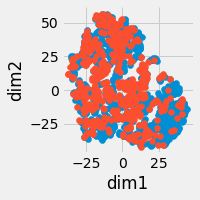

In [164]:
#kl=0.05,ld=32

import seaborn as sn
sn.FacetGrid(tsne_df,hue='label').map(plt.scatter,'dim1','dim2')
plt.show()

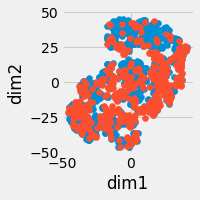

In [148]:
#kl=0.5,ld=32

import seaborn as sn
sn.FacetGrid(tsne_df,hue='label').map(plt.scatter,'dim1','dim2')
plt.show()

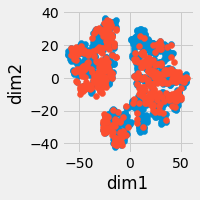

In [133]:
#kl=0.1,ld=32

import seaborn as sn
sn.FacetGrid(tsne_df,hue='label').map(plt.scatter,'dim1','dim2')
plt.show()

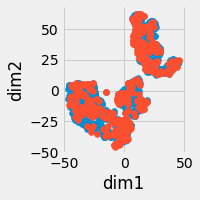

In [118]:
#kl=0,ld=32
import seaborn as sn
sn.FacetGrid(tsne_df,hue='label').map(plt.scatter,'dim1','dim2')
plt.show()

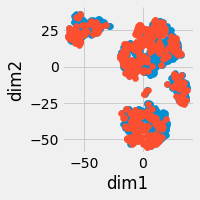

In [101]:
#kl=0,ld=16

import seaborn as sn
sn.FacetGrid(tsne_df,hue='label').map(plt.scatter,'dim1','dim2')
plt.show()

In [61]:
paid_coordi *= 100
default_coordi *= 100

In [62]:
paid_coordi

array([[17801.383 ,  5199.0376],
       [ 2449.2605,  1423.9237],
       [ 5331.4316,  1540.0122],
       ...,
       [ 1291.4767,  1514.8782],
       [ 2535.9324,  1406.4902],
       [ 6571.8086,  6183.566 ]], dtype=float32)

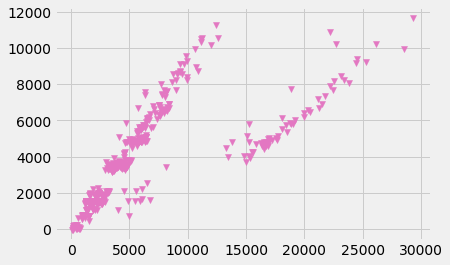

In [63]:
plt.style.use('fivethirtyeight')
plt.scatter(default_coordi[:,0],default_coordi[:,1],marker='v',c = '#e377c2')
plt.show()

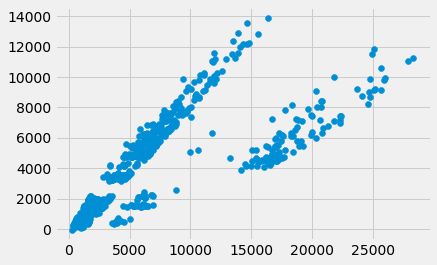

In [64]:
plt.scatter(paid_coordi[:,0],paid_coordi[:,1],marker='o')
plt.show()

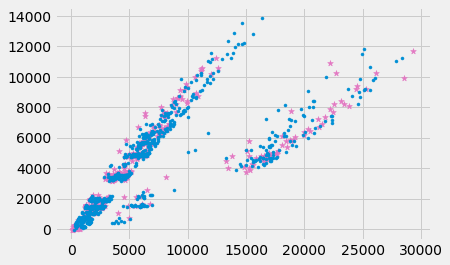

In [65]:
plt.style.use('fivethirtyeight')
plt.scatter(default_coordi[:,0],default_coordi[:,1],marker='*',c = '#e377c2')
plt.scatter(paid_coordi[:,0],paid_coordi[:,1],marker='.')

plt.show()

#https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

##VAE

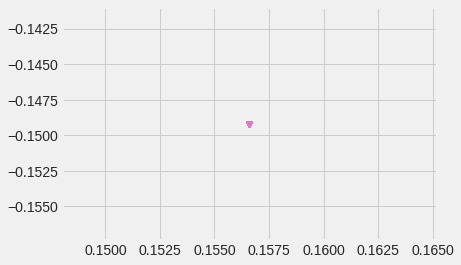

In [160]:
plt.style.use('fivethirtyeight')
plt.scatter(default_coordi[:,0],default_coordi[:,1],marker='v',c = '#e377c2')
plt.show()

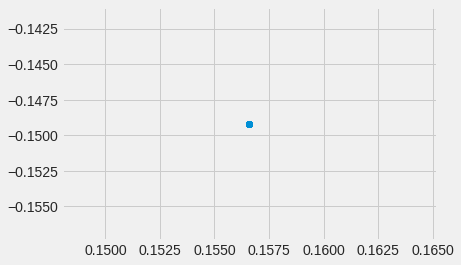

In [161]:
plt.scatter(paid_coordi[:,0],paid_coordi[:,1],marker='o')
plt.show()

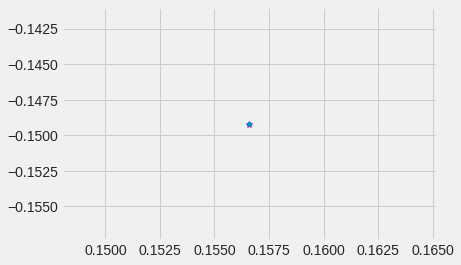

In [162]:
plt.style.use('fivethirtyeight')
plt.scatter(default_coordi[:,0],default_coordi[:,1],marker='*',c = '#e377c2')
plt.scatter(paid_coordi[:,0],paid_coordi[:,1],marker='.')

plt.show()

##AE

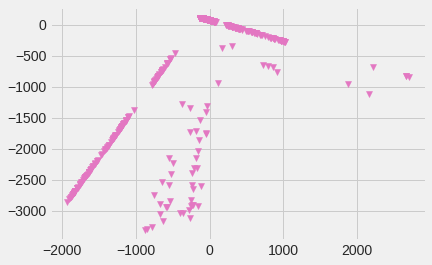

In [144]:
plt.style.use('fivethirtyeight')
plt.scatter(default_coordi[:,0],default_coordi[:,1],marker='v',c = '#e377c2')
plt.show()

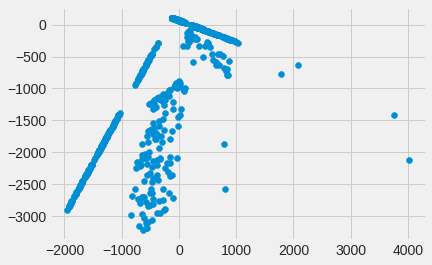

In [145]:
plt.scatter(paid_coordi[:,0],paid_coordi[:,1],marker='o')
plt.show()

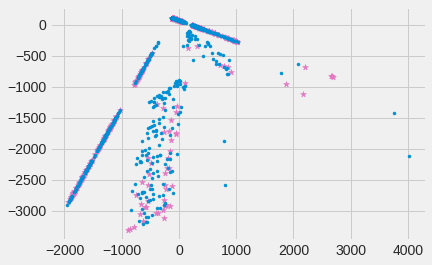

In [146]:
plt.style.use('fivethirtyeight')
plt.scatter(default_coordi[:,0],default_coordi[:,1],marker='*',c = '#e377c2')
plt.scatter(paid_coordi[:,0],paid_coordi[:,1],marker='.')

plt.show()

In [147]:
uni = np.unique(default_coordi[:,1],return_counts=True)
uni

(array([-3308.2424   , -3291.1365   , -3266.8132   , -3170.9739   ,
        -3112.886    , -3054.4717   , -3043.099    , -3041.2253   ,
        -2997.9055   , -2944.5022   , -2944.153    , -2933.617    ,
        -2929.689    , -2911.7244   , -2903.2874   , -2893.5747   ,
        -2868.3687   , -2848.2444   , -2832.5151   , -2814.568    ,
        -2801.4805   , -2778.9348   , -2778.1465   , -2760.5142   ,
        -2749.721    , -2747.0984   , -2732.7627   , -2728.0122   ,
        -2725.9805   , -2723.1082   , -2718.393    , -2718.1248   ,
        -2717.492    , -2711.9016   , -2710.1855   , -2703.604    ,
        -2693.0225   , -2688.6667   , -2685.7078   , -2683.7866   ,
        -2680.7256   , -2679.6235   , -2644.1921   , -2643.5923   ,
        -2642.16     , -2634.745    , -2628.5693   , -2619.5186   ,
        -2610.377    , -2594.5522   , -2586.64     , -2585.8318   ,
        -2569.4568   , -2567.7654   , -2550.8733   , -2545.6677   ,
        -2544.7153   , -2541.9246   , -2511.7275

In [148]:
uni = np.unique(paid_coordi[:,0],return_counts=True)

uni

(array([-1.95449524e+03, -1.92848914e+03, -1.92423193e+03, -1.91676331e+03,
        -1.90953845e+03, -1.90842725e+03, -1.90783252e+03, -1.89930151e+03,
        -1.89302832e+03, -1.88805688e+03, -1.87677856e+03, -1.87458118e+03,
        -1.87271289e+03, -1.83534180e+03, -1.82797852e+03, -1.81892676e+03,
        -1.80262280e+03, -1.80155981e+03, -1.79950769e+03, -1.79156421e+03,
        -1.77410132e+03, -1.77009558e+03, -1.75093359e+03, -1.74971692e+03,
        -1.74668066e+03, -1.74467493e+03, -1.73643774e+03, -1.72533533e+03,
        -1.72061975e+03, -1.71417297e+03, -1.70790540e+03, -1.69663428e+03,
        -1.69256421e+03, -1.69111975e+03, -1.69015137e+03, -1.68804993e+03,
        -1.68684558e+03, -1.67201306e+03, -1.64745630e+03, -1.64449902e+03,
        -1.63586145e+03, -1.63346411e+03, -1.62727966e+03, -1.62503894e+03,
        -1.62476660e+03, -1.62183398e+03, -1.61797888e+03, -1.61423816e+03,
        -1.61380591e+03, -1.60906982e+03, -1.59627979e+03, -1.59457935e+03,
        -1.5

##re_loss = 1 kl_loss = 0 dim = 16




In [71]:
vae.save_weights('./my_checkpoint0')
model0 = VAE(encoder, decoder)
model0.load_weights('./my_checkpoint0')

In [73]:
input_arr = tf.random.uniform((1, 42))
input_arr.shape
model0.build(input_arr.shape)
model0.summary()

Model: "vae_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 1, 16), (None, 1, 2035      
_________________________________________________________________
decoder (Functional)         (None, 42)                1517      
Total params: 3,552
Trainable params: 3,552
Non-trainable params: 0
_________________________________________________________________


In [74]:
en_reconstructions_paid = model0.encoder(np.expand_dims(test_input_paid, axis=1))

en_reconstructions_default = model0.encoder(np.expand_dims(test_input_default ,axis=1))

In [75]:
de_reconstructions_paid = model0.decoder(en_reconstructions_paid)

de_reconstructions_default = model0.decoder(en_reconstructions_default)

In [76]:
mae_paid = np.mean(np.abs(np.squeeze(test_input_paid) - np.squeeze(de_reconstructions_paid)), axis=1)
mae_default = np.mean(np.abs(np.squeeze(test_input_default) - np.squeeze(de_reconstructions_default)), axis=1)

In [77]:
mae_paid.mean()

0.14868933337592838

In [78]:
mae_default.mean()

0.1685192917753204

## Reconstructing Test Data

In [ ]:
reconstructions_paid = model.predict(np.expand_dims(test_input_paid, axis = 2))
reconstructions_default = model.predict(np.expand_dims(test_input_default, axis = 2))

In [ ]:
mae_default.shape

(1920,)

In [ ]:
mae_paid = np.mean(np.abs(np.squeeze(test_input_paid) - np.squeeze(reconstructions_paid)), axis=1)
mae_default = np.mean(np.abs(np.squeeze(test_input_default) - np.squeeze(reconstructions_default)), axis=1)

In [ ]:
mae_paid.mean()

0.06295656544415648

In [ ]:
mae_default.mean()

0.06928936402903059

## Plan of Action for the Next Two Weeks



### 1. Clustering of latent representations(Suggestion by Junyi)
#### Train the autoencoder on paid mortgages
#### Extract the latent representations for both paid and defaulted mortgages
#### Cluster these representations using Kmeans
#### t-distributed stochastic neighbor embedding (t-SNE) for visualizing high dimensional data

### 2. Categorical data embedding  

### 3. Compare performance with existing work
#### Deep Learning for Anomaly Detection: A Survey - Chalapathy et.al